In [ ]:
 ! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gpiosenka/autistic-children-data-set-traintestvalidate

 93% 127M/137M [00:00<00:00, 109MB/s]
100% 137M/137M [00:01<00:00, 134MB/s]


In [ ]:
ls /content/autistic-children-data-set-traintestvalidate.zip


/content/autistic-children-data-set-traintestvalidate.zip


In [ ]:
!unzip '/content/autistic-children-data-set-traintestvalidate.zip' -d '/content/data'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/data/consolidated/autistic/0873.jpg  
  inflating: /content/data/consolidated/autistic/0874.jpg  
  inflating: /content/data/consolidated/autistic/0875.jpg  
  inflating: /content/data/consolidated/autistic/0876.jpg  
  inflating: /content/data/consolidated/autistic/0877.jpg  
  inflating: /content/data/consolidated/autistic/0878.jpg  
  inflating: /content/data/consolidated/autistic/0879.jpg  
  inflating: /content/data/consolidated/autistic/0880.jpg  
  inflating: /content/data/consolidated/autistic/0881.jpg  
  inflating: /content/data/consolidated/autistic/0882.jpg  
  inflating: /content/data/consolidated/autistic/0883.jpg  
  inflating: /content/data/consolidated/autistic/0884.jpg  
  inflating: /content/data/consolidated/autistic/0885.jpg  
  inflating: /content/data/consolidated/autistic/0886.jpg  
  inflating: /content/data/consolidated/autistic/0887.jpg  
  inflating: /content/

**Import needed modules**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
from PIL import Image
#import optuna
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

**surpress annoying tensorflow **

In [ ]:
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

**Define the classifier function and defaut parameters**

In [ ]:
def classifier(my_dir,                   # main directory 
               save_dir,                 # directory to store the trained model in
               model_type = 'Mobilenet', # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile', 'DenseNet201
               structure = 3,            # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
               v_split=.10,              # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
               epochs = 15,              # number of epochs to run the model for
               freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
               fine_tune_epochs = 10,    # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
               height = 224,             # height of images to be used by the model
               width = 224,              # width of images to be used by the model      
               bands = 3,                # bands in image 3 for rgb 1 for grey scale 
               batch_size = 32,          # batch size used in generators
               lr = .001,                # initial learning rate
               patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
               stop_patience = 3,        # number of times learning rate can be adjusted with performance improvement before stopping training
               threshold = .90,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
               dwell=False,               # if True when there is no performance improvement model weights set back to best_weights
               factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
               dropout = .4,             # dropout float<1 defines dropout factor
               print_code=10,             # Integer if 0 no file classifications are printed, if >0 is the maximum number misclassified 
                                         # file classifications that will be printed out
               neurons_a= 128,           # number of neurons in Dense layer between base model and top classification layer
               metrics=['accuracy']):    # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics 
    tf.random.set_seed(0)
    if 'accuracy' not in metrics:
        metrics.append('accuracy')
    if structure == 3: # define train, test and valid directories where image files are stored within the main dir directory
        train_dir, test_dir, valid_dir = os.path.join(my_dir, 'train'), os.path.join(my_dir, 'test'), os.path.join (my_dir,'valid')
    elif structure==2: # define train and test directories, no validation directory
        train_dir, test_dir, valid_dir = os.path.join(my_dir, 'train'), os.path.join(my_dir, 'test'), dir
    else: # the data is in a single directory the dir directory set train directory to dir directory
         train_dir, test_dir, valid_dir = my_dir, my_dir, my_dir  
    # create the data generators
    train_gen, test_gen, valid_gen=make_gens(structure, train_dir, test_dir, valid_dir,height, width, bands, batch_size, v_split)
    # display some training images
    show_training_samples(train_gen)
    #create a list of classes from the sub directory names
    class_list=os.listdir(train_dir) # list of class directories within the train directory
    #determine the number of classes
    class_count=len(class_list)
    # make the model basedon input parameters
    model=Models().make_model( model_type,neurons_a, class_count, width, height, bands, lr, freeze, dropout, metrics )
    # determine class weights to handle imbalanced data sets
    class_weight=get_weight_dict(train_dir)
    # create a custom callback using input parameters
    callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_type, freeze=freeze, end_epoch=epochs - 1 )]
    # determine batch sizes for generators and steps per epoch for model.fit
    if structure ==3:# all three generators derived from train, test, valid directory contents
        valid_batch_size, valid_steps = get_bs(valid_dir, batch_size)
        test_batch_size, test_steps = get_bs(test_dir, batch_size)
    elif structure ==2: # train and test generators determined from train and test directories , split train data
                        # into a training generator  and a validation generator
        valid_steps= len(valid_gen.labels)//batch_size + 1
        valid_batch_size= batch_size
        test_batch_size, test_steps=get_bs(test_dir, batch_size) 
    else: # all data is in directory dir
        valid_steps= len(valid_gen.labels)//batch_size + 1
        valid_batch_size=batch_size
        test_steps=valid_steps
        test_batch_size=batch_size
    results=model.fit(x=train_gen,  epochs=epochs, verbose=2, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)
    tr_plot(results, 0)  # plot the loss and accuracy metrics
    model.set_weights(LRA.best_weights) # load the best weights saved during training
    e_dict=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=None, return_dict=True)
    acc=display_eval_metrics(e_dict)
    msg=f'accuracy on the test set is {acc:5.2f} %'
    print_in_color(msg, (0,255,0),(55,65,80))
    save_id=str (model_type +  '-' + str(acc)[:str(acc).rfind('.')+3] + '.h5')
    save_loc=os.path.join(save_dir, save_id)
    model.save(save_loc)
    preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=None)
    print_info( test_dir, test_gen, preds, print_code )
    if freeze: # Start Fine Tunning
        msg='Starting Fine Tuning of Model data from last epoch is shown below'
        print_in_color(msg, (255,255,0), (55,65,80))
        for layer in model.layers:  # make all layers trainable
            layer.trainable==True
        start_epoch=epochs
        total_epochs=start_epoch + fine_tune_epochs
        # train model for fine tunning
        data=model.fit(x=train_gen,  epochs=total_epochs, verbose=2, callbacks=callbacks,  validation_data=valid_gen,  initial_epoch=start_epoch)
        tr_plot(data, start_epoch)  # plot training graph
        model.set_weights(LRA.best_weights) # load best weights from fine tunning
        save_loc=os.path.join(save_dir, str(acc)[:str(acc).rfind('.')+3] + '.h5')
        model.save(save_loc)
        e_dict=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=None, return_dict=True)
        acc=display_eval_metrics(e_dict)
        msg=f'accuracy of fine tuned model on the test set is {acc:5.2f} %'
        print_in_color(msg, (0,255,0),(55,65,80))
        preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=test_steps)
        #show_images( test_dir, test_gen, preds, max_images)
        print_info( test_dir, test_gen, preds, print_code )
    acc=display_eval_metrics(e_dict)
    msg=' Process complete'
    print_in_color (msg, (0,255,0), (55,65,80))
    return e_dict

**Define function to display sample training** 

In [ ]:
def show_training_samples(gen):
    class_dict=gen.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key        
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=new_dict[index]
        plt.title(class_name, color='white')
        plt.axis('off')
    plt.show()
    

**Define function to create data generators**

In [ ]:
def make_gens ( structure, train_dir, test_dir, valid_dir,height, width, bands, batch_size, v_split):
    if bands==3:
        color_mode = 'rgb'
    else:
        color_mode = 'grayscale'
    if structure ==3:
        train_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                     horizontal_flip=True).flow_from_directory( train_dir, target_size=(width, height),
                                                                               batch_size=batch_size, seed=123,
                                                                               class_mode='categorical', color_mode=color_mode,shuffle=True)
        valid_batch_size, valid_steps=get_bs( valid_dir, batch_size)
        valid_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                    horizontal_flip=False).flow_from_directory(valid_dir,target_size=(width, height),
                                                                               batch_size=valid_batch_size,
                                                                               class_mode='categorical',color_mode=color_mode, shuffle=False)
        test_batch_size, test_steps=get_bs(test_dir, batch_size)
        test_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                   horizontal_flip=False).flow_from_directory(test_dir, target_size=(width, height),
                                                                              batch_size=test_batch_size,
                                                                              class_mode='categorical',color_mode=color_mode, shuffle=False )
        return train_gen, test_gen, valid_gen
    if structure ==2:
        train_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,validation_split=v_split,
                                     horizontal_flip=True).flow_from_directory( train_dir, target_size=(width, height), 
                                                                               batch_size=batch_size, seed=123,
                                                                               class_mode='categorical', color_mode=color_mode, subset='training') 
        valid_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, validation_split=v_split,
                                    horizontal_flip=False).flow_from_directory( train_dir, target_size=(width, height),
                                                                               batch_size=batch_size, seed=123, 
                                                                               class_mode='categorical', color_mode=color_mode, subset='validation') 
        test_batch_size, test_steps=get_bs(test_dir, batch_size)                                                                                                                         
        test_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                    horizontal_flip=False).flow_from_directory(test_dir, target_size=(width, height),
                                                                               batch_size=test_batch_size,
                                                                               class_mode='categorical',color_mode=color_mode, shuffle=False ) 
        return train_gen, test_gen, valid_gen
    train_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,validation_split=v_split,
                                     horizontal_flip=True).flow_from_directory( train_dir, target_size=(width, height), 
                                                                               batch_size=batch_size, seed=123,
                                                                               class_mode='categorical', color_mode=color_mode, subset='training') 
    valid_gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, validation_split=v_split,
                                    horizontal_flip=False).flow_from_directory( train_dir, target_size=(width, height),
                                                                               batch_size=batch_size, seed=123, 
                                                                               class_mode='categorical', color_mode=color_mode, subset='validation')
    
    for i in range(0,10):
        print(valid_gen.labels[i], valid_gen.filenames[i])
    test_gen=valid_gen    
    return train_gen, test_gen, valid_gen

**Define function to determine batch size and steps per epoch**

In [ ]:
def get_bs(dir,b_max):
    # dir is the directory containing the samples, b_max is maximum batch size to allow based on your memory capacity
    # you only want to go through test and validation set once per epoch this function determines needed batch size ans steps per epoch
    length=0
    dir_list=os.listdir(dir)
    for d in dir_list:
        d_path=os.path.join (dir,d)
        length=length + len(os.listdir(d_path))
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]  
    return batch_size,int(length/batch_size)

**Create the Models class**

In [ ]:
class Models:         
    def make_model(self, model_type,neurons_a, class_count, width, height, bands, lr, freeze, dropout, metrics ):
        self.model_type=model_type
        self.class_count=class_count
        self.width=width
        self.height=height
        self.bands=bands
        self.lr=lr   
        self.freeze=freeze
        self.dropout=dropout
        self.metrics=metrics
        self.neurons_a=neurons_a        
        img_shape=(self.width, self.height,self.bands)
        model_list=['Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile', 'DenseNet201']
        if self.model_type not in model_list:
            msg=f'ERROR the model name you specified {self.model_type} is not an allowed model name'
            print_in_color(msg, (255,0,0),(55,65,80))
            return None       
        if self.model_type=='Mobilenet':
            base_model=tf.keras.applications.mobilenet.MobileNet( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet',dropout=.4) 
        elif self.model_type=='MobilenetV2':
            base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet')        
        elif self.model_type=='VGG19':
            base_model=tf.keras.applications.VGG19( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='InceptionV3':
            base_model=tf.keras.applications.InceptionV3( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='NASNetMobile':
            base_model=tf.keras.applications.NASNetMobile( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        elif self.model_type=='DenseNet201':
            base_model=tf.keras.applications.densenet.DenseNet201( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet' )
        else:
            base_model=tf.keras.applications.ResNet50V2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet')
        
        if self.freeze:
            for layer in base_model.layers:#train top 20 layers of base model
                layer.trainable=False            
        x=base_model.output
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x = Dense(self.neurons_a, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
        x=Dropout(rate=dropout, seed=123)(x) 
        #x = Dense(self.neurons_b, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                #bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
        #x=Dropout(rate=dropout, seed=123)(x) 
        output=Dense(self.class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
        model=Model(inputs=base_model.input, outputs=output)
        model.compile(Adamax(lr=self.lr), loss='categorical_crossentropy', metrics=self.metrics) 
        return model

**Define function that prints a string msg in specified foreground and background rgb colors**

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

**Define a function that calculates the class_weight dictionary for use in model.fit**

In [ ]:
def get_weight_dict(dir):    
    total_samples=0
    class_weight={}
    max_length=0
    class_list=os.listdir(dir)
    class_count=len(class_list)
    for i,c in enumerate(class_list):
        c_path=os.path.join(dir,c)
        length=len(os.listdir(c_path))
        if length>max_length:
            max_length=length
        class_weight[i]=length
        total_samples=total_samples + length
    for i in range(0, class_count):
        class_weight[i]=class_weight[i]/max_length
    return class_weight

**Create subclass of callback class as custom callback to adjust learning rate and save best weights**

patience is an integer that specifies how many consecutive epoch can occur until learning rate is adjusted threshold is a float. It specifies that if training accuracy is above this level learning rate will be adjusted based on validation loss factor is a float <1 that specifies the factor by which the current learning rate will be multiplied by class variable LRA.best_weights stores the model weights for the epoch with the lowest validation loss after train set the model weights with model.load_weights(LRA.best_weights) then do predictions on the test set

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,end_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        self.count=0 # initialize counter that counts epochs with no improvement
        self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.end_epoch=end_epoch # value of the number of epochs to run
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
            
    def on_epoch_begin(self, epoch, logs=None): # just used to print data from previous epoch
        if epoch != 0:
            msgs=f'for epoch {epoch} '
            msgs=msgs + LRA.msg
            print_in_color(msgs, (255,255,0), (55,65,80))
            
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                LRA.msg= f' training accuracy improved from  {self.highest_tracc:7.4f} to {acc:7.4f} learning rate held at {lr:9.6f}'
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss             
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                    msgs=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    LRA.msg=msgs + f' for {self.patience } epochs, lr adjusted to {self.lr:10.8f}'                    
                else:
                    self.count=self.count +1 # increment patience counter
                    LRA.msg=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    #print_in_color(msg, (255,255,0), (55,65,80))
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                msgs=f' validation loss improved from {self.lowest_vloss:8.5f} to {v_loss:8.5}, saving best weights'
                LRA.msg=msgs + f' learning rate held at {self.lr:10.8f}'
                #print_in_color(msg, (0,255,0), (55,65,80))
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0                    
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted                    
                    msgs=f' val_loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f} for {self.patience} epochs'
                    LRA.msg=msgs + f', lr adjusted to {self.lr:10.8f}'
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter
                    LRA.msg=f' validation loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f}'
                    #print_in_color(msg, (255,255,0), (55,65,80)) 
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        if epoch==self.end_epoch:
            print_in_color(LRA.msg, (255,255,0), (55,65,80)) # print out data for the final epoch
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            LRA.msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(LRA.msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

**define function to plot training results**

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


**Define function to print metrics from model.evaluate**

In [ ]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    print_in_color(msg, (255,255,0), (55,65,80))
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    print_in_color(msg, (255,255,0), (55,65,80))
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

**Define method to show misclassified images**

In [ ]:
def show_images( test_dir, test_gen, preds, max_images ):
    if max_images==0:
        return
    new_dict={}
    class_dict=test_gen.class_indices
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    errors=0
    labels= test_gen.labels
    file_names= test_gen.filenames 
     # determine the number of misclassifications
    for i, p in enumerate(preds):
        if np.argmax(p) != labels[i]: # a misclassification has occurred
            errors=errors + 1        
    if errors>0:
        if errors<=max_images:
            msg=f'The {errors} images that were misclassified are shown below'
        else: msg=f'Only {max_images} of the {errors} images that were misclassified are shown below'
        print_in_color(msg,(0,255,0),(55,65,80))
        rows=int(np.ceil(errors/3))
        height=rows * 5        
        plt.figure(figsize=(20,height ))
        j=1
        for i,p in enumerate(preds):
            if j <=max_images:
                if np.argmax(p) != labels[i]: # a misclassification has occurred
                    error_class=new_dict(np.argmax(p))  # string of class name
                    path_to_class=os.path.join(test_dir, error_class)
                    class_file_list-os.listdir(path_to_class)
                    path_to_error_img= class_file_list[0] # select the firstimage in the list
                    img_path=os.path.join(test_dir,file_names[i] ) # path to the image in the test directory
                    plt.subplot(rows, 6, j)                
                    j=j + 1
                    img_true = Image.open(img_path)
                    img_true=img_true.resize((224,224))
                    img_error=Image.open(error_path)
                    img_error=img_error.resize(224,224)
                    plt.axis('off')
                    title=file_names[i][:18]
                    plt.title(title)
                    plt.imshow(np.asarray(img_true)) 
                    plt.imshow(np.asarray(img_error)) 
            else:
                break
        plt.show()
    else:
        msg='With 100% accuracy there are no misclassified images to show'
        print_in_color(msg,(0,255,0), (55,65,80))
    return 

**Define function to print out information on misclassified images**

In [ ]:
def print_info( test_dir, test_gen, preds, print_code ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    classes=list(new_dict.values())     # list of string of class names
    errors=0    
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(pred_index)
            errors=errors + 1
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
   
    

**Example of use**

Found 2536 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


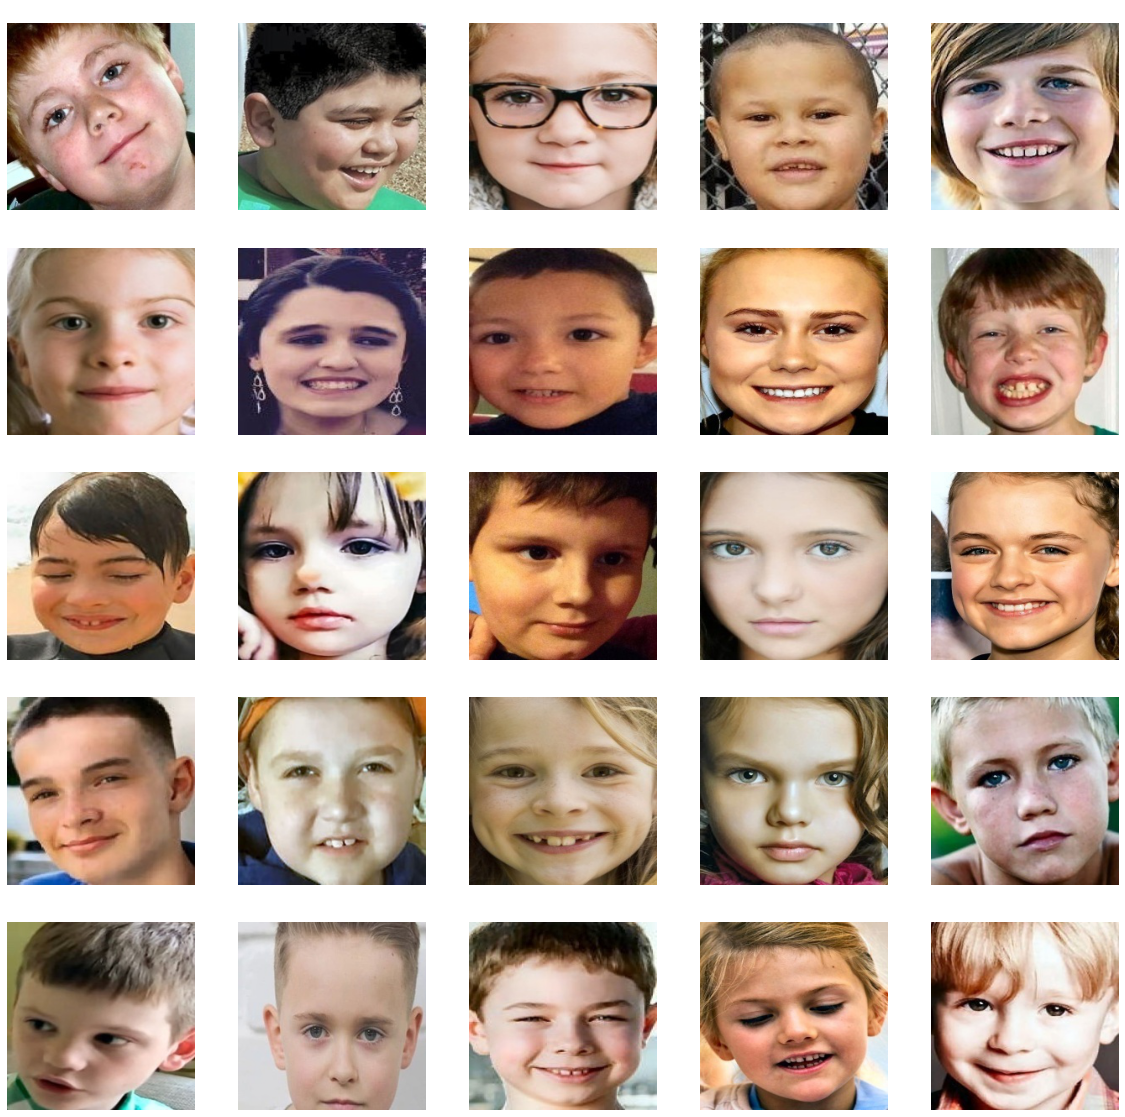

17227776/17225924 [==============================] - 0s 0us/step
 Starting training using base model Mobilenet training all layers 

Epoch 1/20
80/80 - 507s - loss: 13.4139 - accuracy: 0.7472 - val_loss: 11.4481 - val_accuracy: 0.5200
Epoch 2/20
for epoch 1  training accuracy improved from   0.0000 to  0.7472 learning rate held at  0.001000

80/80 - 502s - loss: 7.3345 - accuracy: 0.8442 - val_loss: 6.2028 - val_accuracy: 0.7700
Epoch 3/20
for epoch 2  training accuracy improved from   0.7472 to  0.8442 learning rate held at  0.001000

80/80 - 497s - loss: 4.6972 - accuracy: 0.9014 - val_loss: 4.2588 - val_accuracy: 0.7300
Epoch 4/20
for epoch 3  training accuracy improved from   0.8442 to  0.9014 learning rate held at  0.001000

80/80 - 501s - loss: 3.2388 - accuracy: 0.9338 - val_loss: 3.0347 - val_accuracy: 0.8100
Epoch 5/20
for epoch 4  training accuracy improved from   0.9014 to  0.9338 learning rate held at  0.001000

80/80 - 499s - loss: 2.3034 - accuracy: 0.9606 - val_loss: 2.2

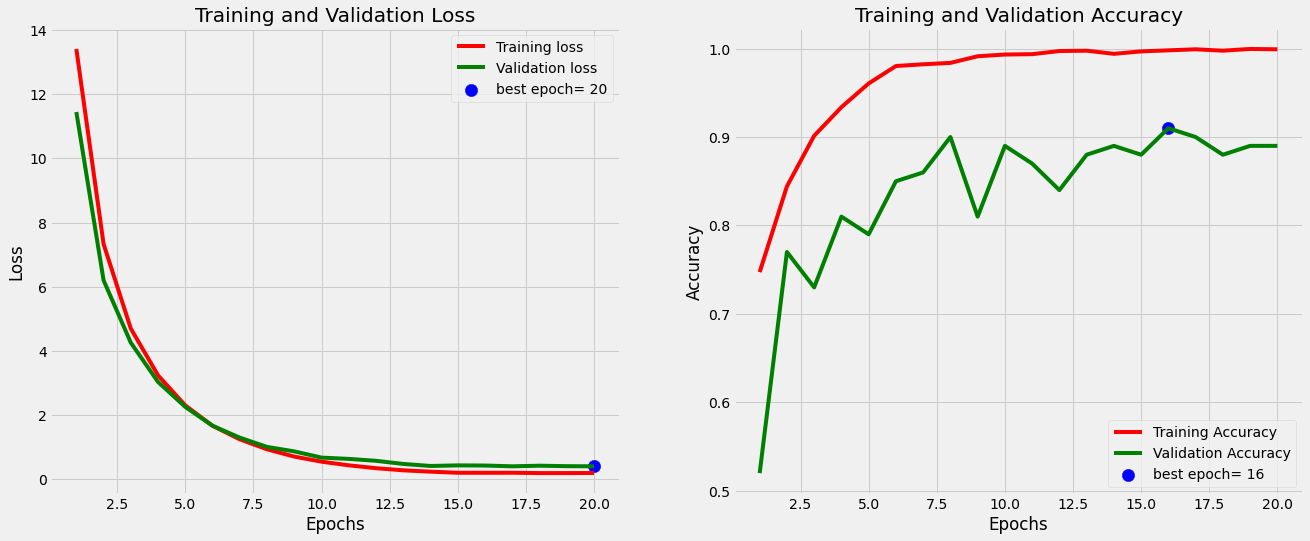

10/10 [==============================] - 12s 1s/step - loss: 0.4244 - accuracy: 0.9000
Model Metrics after Training

         Metric                  Value          

          loss                  0.42439         
        accuracy                0.90000         
accuracy on the test set is 90.00 %

          Filename                Predicted Class                True Class           Probability   

      autistic/007.jpg              non_autistic                  autistic              0.9862

      autistic/013.jpg              non_autistic                  autistic              0.7248

      autistic/025.jpg              non_autistic                  autistic              0.9151

      autistic/031.jpg              non_autistic                  autistic              0.7547

      autistic/041.jpg              non_autistic                  autistic              0.7715

      autistic/044.jpg              non_autistic                  autistic              0.9155

      autistic/059.j

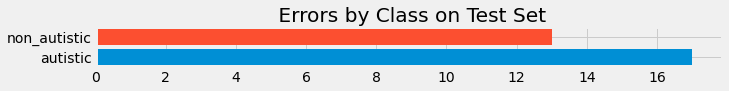

In [ ]:
#mse=tf.keras.metrics.MeanSquaredError() # if you use a metric define it here - example
#auc=tf.keras.metrics.AUC(num_thresholds=200, curve="ROC",  summation_method="interpolation",
                    #name='auc', dtype=None, thresholds=None,  multi_label=False, label_weights=None,) - example
sdir = r'/content/data'
metric_dict=classifier(my_dir=sdir,   # main directory that stores the data - function returns dictionary of trained model metrics 
            save_dir=r'./',      # directory to store the trained model in
            model_type = 'Mobilenet', # select from Mobilenet','MobilenetV2', 'VGG19','InceptionV3', 'ResNet50V2', 'NASNetMobile', 'DenseNet201
            structure = 3,            # 3 for train,test, valid directories, 2 for train, test directories 1 for a single directory dir  
            v_split=.025,             # only valid if structure =1 or 2. Then it is percentage of training images that will be used for validation
            epochs = 20,               # number of epochs to run the model for
            freeze = False,           # if False all layers of the model are trained for epoch epochs, if True layersof basemodel are not trained
            fine_tune_epochs= 10,     # only used when freeze=True, then all model layers are trained for this value epochs after  initial epochs
            height = 224,             # height of images to be used by the model
            width = 224,              # width of images to be used by the model      
            bands = 3,                # bands in image 3 for rgb 1 for grey scale
            batch_size = 32,          # batch size used in generators
            lr = .001,                # initial learning rate
            patience = 1,             # number of epochs with no performance improvement before learning rate is adjusted
            stop_patience = 3,        # number of times learning rate can be adjusted with performance improvement before stopping training
            threshold = .95,           # float value is training accuracy<threshold adjust lr on accuracy, above threshold adjust on validation loss
            dwell=True,               # if True model weights are set back to best_weights if performance did not improve for current epoch
            factor = .5,              # float <1 factor to multiply current learning rate by if performance does not improve
            dropout = .4,             # dropout float<1 defines dropout factor
            print_code=50 ,           # max number of misclassified files to print out 
            neurons_a= 1024,          # number of neurons in dense layer between base model  and final top classification layer           
            metrics=[])               # create a list of desired metrics Note 'accuracy' metric is automatically added to the list of metrics  